# Model train
---

## Import

In [77]:
import torch
from torch_geometric.datasets import Reddit, Amazon
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
from torch.functional import F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.loader import NeighborSampler, NeighborLoader
from torch_geometric.data import Data
import torch.optim as optim
import seaborn as sns
from models import *
import tqdm

np.random.seed(0)

## Read, understand and prepare the data

In [64]:
# node_data = pd.read_parquet('data/amazon_product_data_word2vec.parquet')
data = torch.load('data/amazon_product_data.pt')
data.num_classes = data.y.unique().shape[0]

/tmp/ipykernel_433170/1077470556.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('data/amazon_product_data.pt')


### Main info

In [62]:
print("data", data)
print("num nodes", data.num_nodes)
print("Num edges", data.num_edges)
print("num node features", data.num_node_features)
print("is undirected", data.is_undirected())
print("is directed", data.is_directed())
print("num edge features", data.num_edge_features)
print('num classes', data.num_classes)

data Data(x=[863130, 100], edge_index=[2, 815222], y=[863130], num_classes=27)
num nodes 863130
Num edges 815222
num node features 100
is undirected False
is directed True
num edge features 0
num classes 27


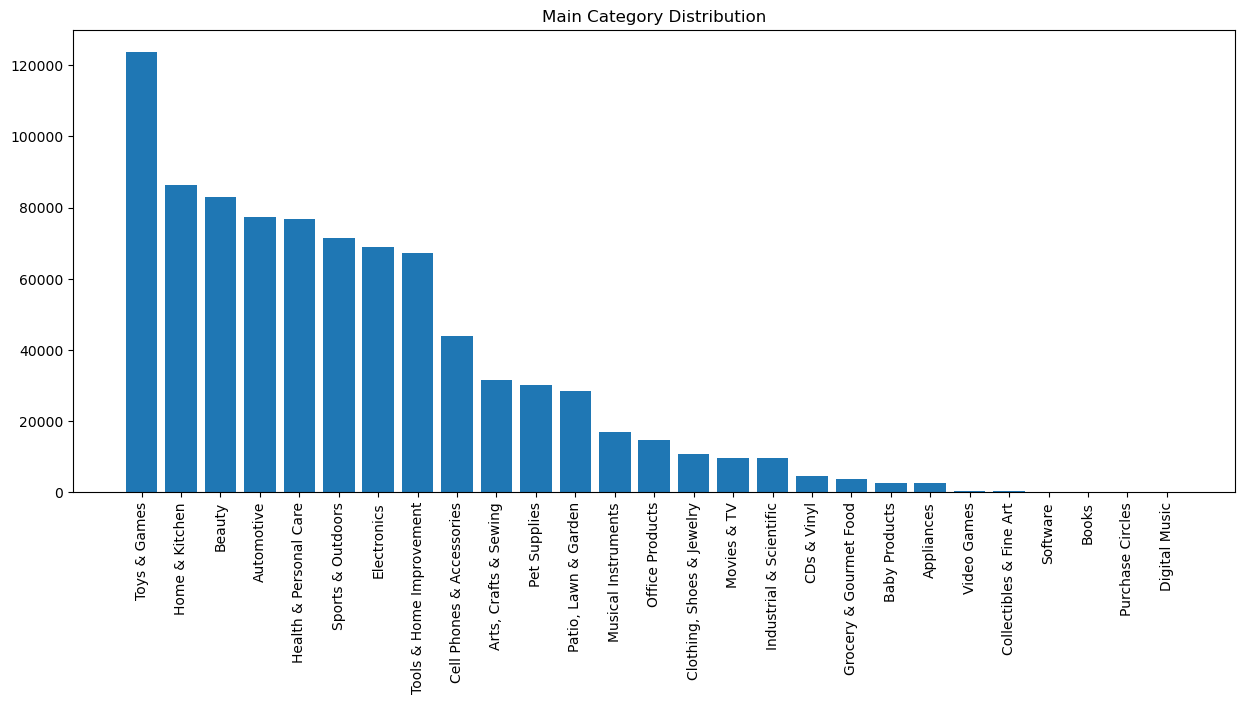

In [67]:
value_counts = node_data['main_category'].value_counts()

# plot a bar chart of the main categories
plt.figure(figsize=(15, 6))
plt.bar(value_counts.index, value_counts.values)
plt.xticks(rotation=90)
plt.title('Main Category Distribution')
plt.show()

### Visualization

In [78]:
# from torch_geometric.utils import to_networkx

# G = to_networkx(data, to_undirected=True)
# visualize_graph(G, color=data.y)

In [79]:
# def create_data_split_masks(data, train_ratio=0.8, val_ratio=0.1):
#   # Total number of nodes
#   num_nodes = data.num_nodes

#   # Randomly permute the node indices
#   perm = torch.randperm(num_nodes)

#   # Calculate split sizes
#   train_size = int(train_ratio * num_nodes)
#   val_size = int(val_ratio * num_nodes)
#   test_size = num_nodes - train_size - val_size

#   # Create masks for train, validation, and test
#   train_mask = torch.zeros(num_nodes, dtype=torch.bool)
#   val_mask = torch.zeros(num_nodes, dtype=torch.bool)
#   test_mask = torch.zeros(num_nodes, dtype=torch.bool)

#   # Assign masks
#   train_mask[perm[:train_size]] = True
#   val_mask[perm[train_size:train_size + val_size]] = True
#   test_mask[perm[train_size + val_size:]] = True

#   # Assign masks to the data object
#   data.train_mask = train_mask
#   data.val_mask = val_mask
#   data.test_mask = test_mask
  
#   return data
    

### Preparation for model training

In [80]:
def create_masks(data, train_ratio, val_ratio):
  num_nodes = data.num_nodes
  indices = list(range(num_nodes))
  np.random.shuffle(indices)
  
  # Create masks
  train_mask = torch.zeros(num_nodes, dtype=torch.bool)
  val_mask = torch.zeros(num_nodes, dtype=torch.bool)
  test_mask = torch.zeros(num_nodes, dtype=torch.bool)
  
  # Set proportions for train, val, and test
  train_end = int(train_ratio * num_nodes)
  val_end = train_end + int(val_ratio * num_nodes)
  train_mask[indices[:train_end]] = True
  val_mask[indices[train_end:val_end]] = True
  test_mask[indices[val_end:]] = True
  
  # Assign the custom masks to the dataset
  data.train_mask = train_mask
  data.val_mask = val_mask
  data.test_mask = test_mask


def train_test_split_graph(data: Data, train_ratio: float, val_ratio: float, batch_size: int):
    """
    Split the graph data into train, validation, and test sets
    :param data: The graph data
    :param train_ratio: The ratio of the training set
    :param val_ratio: The ratio of the validation set
    :param batch_size: The batch size
    
    :return: The train, validation, and test data loaders
    """

    # Call the function to create masks
    create_masks(data, train_ratio, val_ratio)

    # train, validation, and test node indices based on the masks
    train_idx = data.train_mask.nonzero(as_tuple=False).view(-1)
    val_idx = data.val_mask.nonzero(as_tuple=False).view(-1)
    test_idx = data.test_mask.nonzero(as_tuple=False).view(-1)
    
    def create_data_loader(data, indices):
        return DataLoader(data[indices], batch_size=batch_size, shuffle=True)
      
    def create_neighbor_loader(data, indices, batch_size=batch_size):
        return NeighborLoader(data, num_neighbors=[30] * 2, batch_size=batch_size, input_nodes=indices)

    # create the data loaders
    train_loader = create_neighbor_loader(data, train_idx)
    val_loader = create_neighbor_loader(data, val_idx)
    test_loader = create_neighbor_loader(data, test_idx)

    return train_loader, val_loader, test_loader

## Model training

### Models

In [81]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.linear1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.linear2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.conv2(h, edge_index)
        h = F.relu(h)
        x = self.linear1(h)
        x = F.relu(x)
        x = self.linear2(x)

        return F.log_softmax(x, dim=1)


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.linear1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.linear2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.conv2(h, edge_index)
        h = F.relu(h)
        x = self.linear1(h)
        x = F.relu(x)
        x = self.linear2(x)

        return F.log_softmax(x, dim=1)

### Training functions

In [82]:
# def train_epoch(model, optimizer, loader, device):
#     """Train the model for one epoch using NeighborSampler mini-batches."""
#     model.train()
#     b_losses = []
#     b_accuracies = []

#     for batch in loader:
#         optimizer.zero_grad()
#         batch.to(device)
        
#         out = model(batch.x, batch.edge_index)
#         loss = F.nll_loss(out, batch.y)
        
#         # Backpropagation
#         loss.backward()
#         optimizer.step()
        
#         b_losses.append(loss.item())
#         b_acc = (out.argmax(dim=1) == batch.y).sum().item() / batch.y.size(0)
#         b_accuracies.append(b_acc)
        
#     return np.mean(b_losses), np.mean(b_accuracies)



# @torch.no_grad()
# def evaluate(model, data_loader, device, data):
#     """Evaluate the model on the validation or test set using NeighborSampler mini-batches."""
#     model.eval()
#     total_correct = 0

#     for batch_size, n_id, adjs in data_loader:
#         adjs = [adj.to(device) for adj in adjs]

#         # Compute predictions for all nodes in the mini-batch
#         x_input = data.x[n_id].to(device)
#         out = model(x_input, adjs[0].edge_index)

#         # Get predictions only for the first `batch_size` target nodes
#         pred = out[:batch_size].max(dim=1)[1]

#         # Compare with the actual labels of the target nodes
#         total_correct += (pred ==
#                           data.y[n_id[:batch_size]].to(device)).sum().item()

#     # Calculate accuracy based on the number of target nodes in the entire set
#     return total_correct / len(data_loader.dataset)

In [92]:
def train_epoch(model, optimizer, loss_fn, train_loader, device, print_every):
    model.train()
    b_losses = []
    b_accuracies = []

    # for batch in tqdm(train_loader, desc="Training", leave=False):
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        out = model(batch.x, batch.edge_index)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()

        b_losses.append(loss.item())
        b_acc = (out.argmax(dim=1) == batch.y).sum().item() / batch.y.size(0)
        b_accuracies.append(b_acc)

    return np.mean(b_losses), np.mean(b_accuracies)


@torch.no_grad()
def validate(model, loss_fn, val_loader, device):
    model.eval()
    total_correct = 0
    total_loss = 0

    # for batch in tqdm(val_loader, desc="Validation", leave=False):
    for batch in val_loader:
        batch.to(device)
        out = model(batch.x, batch.edge_index)
        loss = loss_fn(out, batch.y)
        total_loss += loss.item()
        total_correct += (out.argmax(dim=1) == batch.y).sum().item()

    return total_loss / len(val_loader), total_correct / len(val_loader.dataset)


def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_epoch(
            model, optimizer, loss_fn, train_loader, device, print_every)
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(
            f"Epoch {epoch}/{num_epochs}: "
            f"Train loss: {train_loss:.3f}, "
            f"Train acc.: {train_acc:.3f}, "
            f"Val. loss: {val_loss:.3f}, "
            f"Val. acc.: {val_acc:.3f}"
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    return model, train_losses, train_accs, val_losses, val_accs

### Actual training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_ratio = 0.8
val_ratio = 0.1

learning_rate = 0.01
weight_decay = 5e-4
batch_size = 64


train_loader, val_loader, test_loader = train_test_split_graph(data, train_ratio, val_ratio, batch_size)

# Initialize the model and optimizer
model = GAT(in_channels=data.num_node_features, hidden_channels=64, out_channels=data.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.NLLLoss()

# Train the model
model, train_losses, train_accs, val_losses, val_accs = training_loop(
  model, optimizer, loss_fn, train_loader, val_loader, num_epochs=10, print_every=1
)

/home/lucamodica/mambaforge/envs/rigged/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Starting training
Epoch 1/10: Train loss: 1.670, Train acc.: 0.495, Val. loss: 1.531, Val. acc.: 2.400
Epoch 2/10: Train loss: 1.227, Train acc.: 0.650, Val. loss: 1.320, Val. acc.: 2.632
Epoch 3/10: Train loss: 1.098, Train acc.: 0.691, Val. loss: 1.230, Val. acc.: 2.733


## Evaluation